In [1]:
from matplotlib import pyplot as plt

In [2]:
from numpy import array
from numpy.linalg import norm
from math import pi, cos, sin, atan2, copysign
import numpy as np
from time import sleep

#from IK import L0, L12, L23, L34, L45, bodyH
from design_helpers import gen_sides, torque, snapshot
from poses import LegGeom, LegDef
from IK import ALL_FEET_DOWN_TIME_FRAC, TRANSITION_FRAC, FH_FRAC, FH, Gaits
# L0 is the dynamic length of the leg? from pivot to ground contact?
from intersections import intersectLines

# Numa V2
L0=135; L12=58; L23=65; L34=130; L45=5;
bodyH=83

#legLen = 1.00*L0
legLen = 90

masses = [115, 20, 0] # masses in grams for segments 23, 34, 45 respectively. 55g per AX12 servo
body_mass = 2000/2 + sum(masses) # 2kg / 2 + a leg

def gen_numa2_legs():
# 4\ __^__ /3
#   |     | 
#   |numa2| 
#   |_____| 
# 1/       \2
    stance = 0
    offsets_dict = {
            "aoffset1": 45.0,
            "aoffset2": -31.54,
            "aoffset3": -31.54,
            "a1stance": stance,
            "a1stance_rear": stance,
            "L0": 135, # mm - pretty close to actual...
            "L12": 58,
            "L23": 65,
            "L34": 130,
            "L45": 5,  # This is fake right?
            }
    leg_model = LegGeom(offsets_dict)

    # leg_geom, s1_sign, s2_sign, s3_sign, s4_sign=None, front_leg=True):
    leg1 = LegDef(leg_model, offsets_dict,  1,  1, -1)
    leg2 = LegDef(leg_model, offsets_dict, -1, -1,  1)
    leg3 = LegDef(leg_model, offsets_dict,  1,  1, -1, front_leg=True)
    leg4 = LegDef(leg_model, offsets_dict, -1, -1,  1, front_leg=True)

    return leg_model, leg1, leg2, leg3, leg4

In [3]:
# sides are the leg edge we worry about colliding.
# These are two points as vectors from the base of a leg segment
# Numa V2
side23 = [[24.77, -35.15],[24.77+17.78, -6.17]]
side34 = [[24.95, -9.01],[24.95+35.81, -16.09]]
   

Now what am I doing?

In [4]:
def snapshot(gait, ms, loopLength=10000, ang_dir=0.0):
    """Get leg position at a single time within the loop length"""
    
    travRate = 25 # distance in mm that feet travel in a straight line back and forth
    times = []
    points = []

    half_loopLength = loopLength/2.0
    double_travRate = 2 * travRate
    #gait = Gaits()

    # TODO move this
    #ms = 0 #0
    turnTimeOffset = 0 # probalby don't need this for now except as placeholder
    now2 = (ms - turnTimeOffset) % loopLength
    now3 = (ms - turnTimeOffset +  half_loopLength) % loopLength
    now4 = loopLength - (ms - turnTimeOffset) % loopLength
    now1 = loopLength - (ms - turnTimeOffset + half_loopLength) % loopLength

    gait.initTrig()
    gait.walk_code(loopLength, half_loopLength, travRate, 2*travRate,
                  now1, now2, now3, now4, ang_dir)

In [5]:
def mkpts():# calculate the points I want to plot: aka the servo joints
    pt1 = array([L0, 0])
    pt2 = pt1 + array([L12,0])
    pt3 = pt2 + gait.v23 # we do this negative in the code, too
    pt4 = pt3 + [gait.v34[0], -gait.v34[1]]
    pt5 = pt4 + [0, -L45] #[10,0]#
    pt0 = pt1 - [0, bodyH]

    pts = array([pt0, pt1, pt2, pt3, pt4, pt5])
    
    #sides = []
    #sides.append(array([])
    return pts#, sides

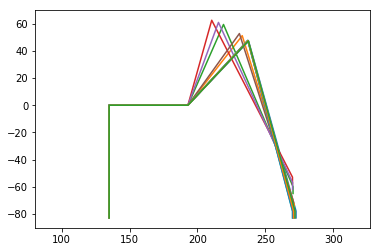

In [6]:
leg_geom, leg1, leg2, leg3, leg4 = gen_numa2_legs()
gait = Gaits(leg_geom, leg1, leg2, leg3, leg4, bodyH)
plt.figure()
ax1 = plt.subplot(1,1,1)
torques = []
foot_height = []
foot_trav = []
intersections = []
#foot_trav0 = L0
for x in range(0,10000,800):
    snapshot(gait, x, 10000)
    pts  = mkpts()
    xvals, yvals = np.transpose(pts[:])
    ax1.set_aspect('equal', 'datalim')
    ax1.plot(xvals, yvals)
    
    # calc torques and leg heights
    torques.append(torque(pts, bodyH, masses=masses))
    foot_height.append(yvals[5] + bodyH)
    foot_trav.append(xvals[5] - 2*legLen)
    
    # gen and plot servo sides
    #sidepts = gen_sides(pts, sides=[side23,side34])
    #for ptset in sidepts[:]:
    #    xvals, yvals = np.transpose(ptset[:])
    #    ax1.plot(xvals, yvals)
    #intersections.append(intersectLines(*[v for pt in sidepts for v in pt][:4]))
torques = np.transpose(array(torques[:]))


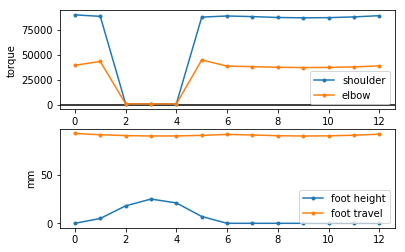

In [7]:
plt.figure()
ax2 = plt.subplot(2,1,1)
ax2.axhline(y=0, color='k')
ax2.set_ylabel("torque")

ax3 = plt.subplot(2,1,2)
ax3.set_ylabel("mm")
#print(torques)

joint_names = {0: "shoulder", 1: "elbow"}
for cnt, dataset in enumerate(torques):#[2]:
    ax2.plot(dataset, label=joint_names[cnt], marker=".")
ax3.plot(foot_height, label="foot height", marker=".")
ax3.plot(foot_trav, label="foot travel", marker=".")
ax2.legend()
ax3.legend()

In [8]:
[x[2] for x in intersections]

[]

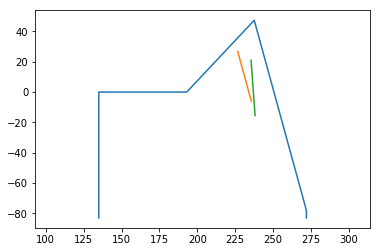

In [9]:
# Looking at a single set of points for debugging
plt.figure()
ax1 = plt.subplot(1,1,1)
#snapshot(gait, x, 10000)
pts  = mkpts()
xvals, yvals = np.transpose(pts[:])
ax1.set_aspect('equal', 'datalim')
ax1.plot(xvals, yvals)

# gen and plot servo sides
sidepts = gen_sides(pts, sides=[side23, side34])
for ptset in sidepts[:]:
    xvals, yvals = np.transpose(ptset[:])
    ax1.plot(xvals, yvals)

In [14]:
from mock_hardware import MockBusToWriteList
from poses import g8Stand, g8FeetDown, g8Crouch, g8Flop
axbus_position_mock = MockBusToWriteList()
for func in (g8Stand, g8FeetDown, g8Crouch, g8Flop):
    func(gait, axbus_position_mock, range(16))
    # Convert from position to degrees to radians... but I forgot servo offsets
    angle2 = (axbus_position_mock.values[-9][0] - 512)/1024 * 300/180*pi
    angle3 = (axbus_position_mock.values[-5][0] - 512)/1024 * 300/180*pi + angle2
    angle4 = (axbus_position_mock.values[-1][0] - 512)/1024 * 300/180*pi + angle3
    #
    pt1 = array([L0, 0])
    pt2 = pt1 + array([L12,0])
    pt3 = pt2 + L23*(cos(angle2)+sin(angle2))
    pt4 = pt3 + L34*(cos(angle3)+sin(angle3))
    pt5 = pt4 + L45*(cos(angle4)+sin(angle4))
    pt0 = pt1 - [0, bodyH]

    pts = array([pt0, pt1, pt2, pt3, pt4, pt5])
    
    

508 666
b'\xfc\x01' 252
b'\x9a\x02' 154
b'4\x03' 52
bytearray(b'\x00') 0


error: unpack requires a bytes object of length 2

In [13]:
axbus_position_mock.values

[(516,),
 (508,),
 (516,),
 (508,),
 (358,),
 (666,),
 (358,),
 (666,),
 (138,),
 (886,),
 (138,),
 (886,),
 (512,),
 (512,),
 (512,),
 (512,)]

In [18]:
import struct
print(struct.pack('<H', int(0)))
print(bytearray([0]))

b'\x00\x00'
bytearray(b'\x00')
